In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import jarque_bera
from statannotations.Annotator import Annotator
import matplotlib.patches as mpatches
import attila_utils

## Data import and engineering

In [2]:
treatments_CO28152 = {
    'A': 'Amiloride TG',
    'B': 'HCQ TG',
    'C': 'HCQ nano TG',
    'D': 'Saline TG',
    'E': 'R-HCQ TG',
    'F': 'S-HCQ TG',
    'G': 'TUDCA TG',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}

treatments_CO28154 = {
    'A': 'Saline TG',
    #'B': 'Amiloride + HCQ TG', # absent from data
    'C': 'TUDCA + HCQ TG',
    'D': 'Arundine low dose TG',
    'E': 'Arundine mid dose TG',
    'F': 'Arundine high dose TG',
    'G': 'Vehicle (Arundine) TG',
    'H': 'Arundine high dose WT',
    #'I': 'Amiloride + HCQ WT', # absent from data
    'J': 'TUDCA + HCQ WT',
    'K': 'Saline WT',
    'L': 'Vehicle (Arundine) WT',
}

fpathl = ['../../resources/QPS/5xFAD-mouse/CO2815' + i + '-biochemistry-cleaned-Abeta.xlsx' for i in ['2', '4']]

def import_helper(fpath, study, treatments, index_cols=['Cohort', 'Group', 'IRN', 'Sex', 'Genotype']):
    df = pd.read_excel(fpath, sheet_name='Abeta', header=[0, 1], index_col=[0, 1, 2, 3, 4])
    ix = df.index.to_frame()#index_cols
    ix = ix.rename(dict(zip(np.arange(len(index_cols)), index_cols)), axis=1)
    ix['Study'] = study
    ix['Treatment'] = ix.Group.apply(lambda x: treatments[x])
    df = pd.DataFrame(df.to_numpy(), index=pd.MultiIndex.from_frame(ix), columns=df.columns)
    return(df)

Z = zip(fpathl, ['CO28152', 'CO28154'], [treatments_CO28152, treatments_CO28154])
Abeta = pd.concat([import_helper(f, s, t) for f, s, t in Z], axis=0)
Abeta

CX FA  \
Genotype                                                                 Aβ40   
Cohort Group IRN     Sex Genotype Study   Treatment                             
I      A     15117   f   tg/wt    CO28152 Amiloride TG           17651.361718   
             15119   f   tg/wt    CO28152 Amiloride TG           15331.812020   
             14627 A f   tg/wt    CO28152 Amiloride TG           16698.646055   
III    A     15161   f   tg/wt    CO28152 Amiloride TG           10839.483178   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            4339.596561   
...                                                                       ...   
IV     L     15823   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VII    L     16145   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
III    L     16746   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
IV     L     16802   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VI     L     17020   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   

                                                                                \
Genotype                                                                  Aβ42   
Cohort Group IRN     Sex Genotype Study   Treatment                              
I      A     15117   f   tg/wt    CO28152 Amiloride TG           116029.444713   
             15119   f   tg/wt    CO28152 Amiloride TG            93464.357730   
             14627 A f   tg/wt    CO28152 Amiloride TG           109435.604680   
III    A     15161   f   tg/wt    CO28152 Amiloride TG            65693.648426   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            56334.531795   
...                                                                        ...   
IV     L     15823   f   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   
VII    L     16145   f   wt/wt    CO28154 Vehicle (Arundine) WT      26.665591   
III    L     16746   m   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   
IV     L     16802   m   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   
VI     L     17020   m   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   

                                                                        HC FA  \
Genotype                                                                 Aβ40   
Cohort Group IRN     Sex Genotype Study   Treatment                             
I      A     15117   f   tg/wt    CO28152 Amiloride TG           18612.586998   
             15119   f   tg/wt    CO28152 Amiloride TG           17893.589944   
             14627 A f   tg/wt    CO28152 Amiloride TG           21920.822859   
III    A     15161   f   tg/wt    CO28152 Amiloride TG           15996.584917   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            6756.283660   
...                                                                       ...   
IV     L     15823   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VII    L     16145   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
III    L     16746   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
IV     L     16802   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VI     L     17020   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   

                                                                                \
Genotype                                                                  Aβ42   
Cohort Group IRN     Sex Genotype Study   Treatment                              
I      A     15117   f   tg/wt    CO28152 Amiloride TG           110505.749236   
             15119   f   tg/wt    CO28152 Amiloride TG           122377.869230   
             14627 A f   tg/wt    CO28152 Amiloride TG           137676.050925   
III    A     15161   f   tg/wt    CO28152 Amiloride TG           102235.507686   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            63092.054319 

In [3]:
def extract_subset(region_fraction='CX FA', Abeta=Abeta):
    df = Abeta.xs(region_fraction, level=0, axis=1)
    df0 = df.index.to_frame()
    dff = pd.concat([df0, df], axis=1)
    val = dff.melt(id_vars=df0.columns, var_name='Alloform', value_name='Ab')
    val['Ab'] = val.Ab.astype(np.float64)
    region, fraction = region_fraction.split(' ')
    val['Region'] = {'CX': 'cortex', 'HC': 'hippocampus'}[region]
    val['Fraction'] = fraction
    return(val)


In [4]:

Abeta_long = pd.concat([extract_subset(rf) for rf in Abeta.columns.to_frame().iloc[:, 0].unique()], axis=0)
#Abeta_long = pd.DataFrame(Abeta_long.to_numpy(), columns=Abeta_long.columns)
Abeta_long['Ab'] = Abeta_long.Ab.astype(np.float64)
Abeta_long['Fraction'] = pd.Categorical(Abeta_long.Fraction, ordered=True, categories=['FA', 'DEA'])
Abeta_long['Region'] = pd.Categorical(Abeta_long.Region, ordered=True, categories=['cortex', 'hippocampus'])
Abeta_long['Sex'] = pd.Categorical(Abeta_long.Sex, ordered=True, categories=['m', 'f'])
treatment_levels = [
    'Saline TG',
    'TUDCA TG',
    'HCQ TG',
    'TUDCA + HCQ TG',
    'HCQ nano TG',
    'R-HCQ TG',
    'S-HCQ TG',
    'Amiloride TG',
    'Saline WT',
    'TUDCA WT',
    'TUDCA + HCQ WT',
    'Vehicle (Arundine) TG',
    'Arundine low dose TG',
    'Arundine mid dose TG',
    'Arundine high dose TG',
    'Vehicle (Arundine) WT',
    'Arundine high dose WT',
    'DMSO WT',
]
Abeta_long['Treatment'] = pd.Categorical(Abeta_long.Treatment, ordered=True, categories=treatment_levels)
Abeta_long

,Cohort,Group,IRN,Sex,Genotype,Study,Treatment,Alloform,Ab,Region,Fraction
0,I,A,15117,f,tg/wt,CO28152,Amiloride TG,Aβ40,17651.361718,cortex,FA
1,I,A,15119,f,tg/wt,CO28152,Amiloride TG,Aβ40,15331.812020,cortex,FA
2,I,A,14627 A,f,tg/wt,CO28152,Amiloride TG,Aβ40,16698.646055,cortex,FA
3,III,A,15161,f,tg/wt,CO28152,Amiloride TG,Aβ40,10839.483178,cortex,FA
4,II,A,15938,m,tg/wt,CO28152,Amiloride TG,Aβ40,4339.596561,cortex,FA
...,...,...,...,...,...,...,...,...,...,...,...
235,IV,L,15823,f,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA
236,VII,L,16145,f,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA
237,III,L,16746,m,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA
238,IV,L,16802,m,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/498430075.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Abeta_long.groupby('Treatment')['Sex'].apply(lambda x: sum(x == 'm') / sum(x.isin(['m', 'f']))).plot(kind='barh', ax=ax)


Text(0.5, 1.0, 'Fraction of males')

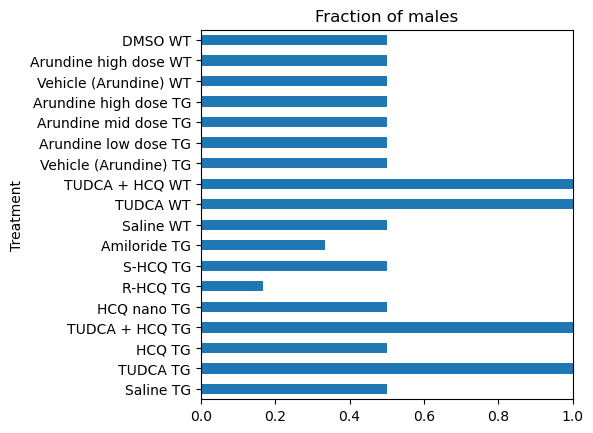

In [5]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
Abeta_long.groupby('Treatment')['Sex'].apply(lambda x: sum(x == 'm') / sum(x.isin(['m', 'f']))).plot(kind='barh', ax=ax)
ax.set_xlim(0, 1)
ax.set_title('Fraction of males')

## t-tests

In [6]:
def my_ttest_one(conditionA, conditionB, study='CO28154', alloform='Aβ40', region='cortex', fraction='FA', Abeta_long=Abeta_long, log_transform=True):
    b = (Abeta_long.Study == study) & (Abeta_long.Alloform == alloform) & (Abeta_long.Region == region) & (Abeta_long.Fraction == fraction)
    data = Abeta_long.loc[b, ['Treatment', 'Ab']]
    helper = np.log if log_transform else np.identity
    a, b = [helper(data.loc[data.Treatment == c, 'Ab'].dropna().to_numpy()) for c in [conditionA, conditionB]]
    res = ttest_ind(a, b)
    d = {a: getattr(res, a) for a in ['statistic', 'pvalue', 'df']}
    df = pd.Series(d).to_frame((conditionA, conditionB, study, alloform, region, fraction)).transpose()
    df = df.rename_axis(('conditionA', 'conditionB', 'study', 'alloform', 'region', 'fraction'), axis=0)
    return(df)

def my_ttest(conditionA, conditionB, study='CO28154', Abeta_long=Abeta_long, log_transform=True):
    al = ['Aβ40', 'Aβ42']
    rl = ['cortex', 'hippocampus']
    fl = ['FA', 'DEA']
    l = [my_ttest_one(conditionA, conditionB, study, a, r, f, Abeta_long, log_transform) for a in al for r in rl for f in fl]
    df = pd.concat(l, axis=0)
    return(df)

aargs = [
    ('Saline TG', 'TUDCA + HCQ TG', 'CO28154'),
    ('Saline TG', 'Saline WT', 'CO28154'),
    ('Saline TG', 'TUDCA TG', 'CO28152'),
    ('Saline TG', 'HCQ TG', 'CO28152'),
    ('Saline TG', 'HCQ nano TG', 'CO28152'),
    ('Saline TG', 'R-HCQ TG', 'CO28152'),
    ('Saline TG', 'S-HCQ TG', 'CO28152'),
    ('Vehicle (Arundine) TG', 'Arundine low dose TG', 'CO28154'),
    ('Vehicle (Arundine) TG', 'Arundine mid dose TG', 'CO28154'),
    ('Vehicle (Arundine) TG', 'Arundine high dose TG', 'CO28154'),
    ('Vehicle (Arundine) TG', 'Vehicle (Arundine) WT', 'CO28154'),
]

ttest_res = pd.concat([my_ttest(*args) for args in aargs], axis=0)
ttest_res.to_csv('../../results/2024-08-08-biochemistry/ttest_res.csv', index=True)

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3933889957.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = ttest_ind(a, b)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3933889957.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = ttest_ind(a, b)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3933889957.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = ttest_ind(a, b)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3933889957.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = ttest_ind(a, b)


## Regression

In [7]:
default_formula = 'np.log(Ab) ~ Treatment + Alloform + Region + Fraction'

def fit_one(formula=default_formula, study='CO28154', treatments=['Saline TG', 'TUDCA + HCQ TG'], Abeta_long=Abeta_long):
    data = Abeta_long.loc[(Abeta_long.Treatment.isin(treatments)) & (Abeta_long.Study == study)]
    data['Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)
    result = smf.ols(formula, data=data.dropna()).fit()
    return(result)

res = fit_one()
res.summary()

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3653947558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             np.log(Ab)   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     764.7
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           5.41e-68
Time:                        19:58:29   Log-Likelihood:                -53.374
No. Observations:                  94   AIC:                             116.7
Df Residuals:                      89   BIC:                             129.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       9.1543      0.100     91.227      0.000       8.955       9.354
Treatment[T.TUDCA + HCQ TG]    -0.3039      0.091     -3.358      0.001      -0.484      -0.124
Alloform[T.Aβ42]                1.6863      0.091     18.618      0.000       1.506       1.866
Region[T.hippocampus]           0.7760      0.091      8.568      0.000       0.596       0.956
Fraction[T.DEA]                -4.7000      0.091    -51.891      0.000      -4.880      -4.520
==============================================================================
Omnibus:                        3.111   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                2.825
Skew:                           0.425   Prob(JB):                        0.244
Kurtosis:                       2.993   Cond. No.                         4.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
formula_l = [
    'np.log(Ab) ~ Treatment',
    'np.log(Ab) ~ Treatment + Alloform + Region + Fraction',
    'np.log(Ab) ~ Treatment + Alloform + Region + Fraction + Treatment * Region * Fraction - Treatment : Region : Fraction',
    'np.log(Ab) ~ (Treatment + Alloform + Region + Fraction) ** 2',
    #'np.log(Ab) ~ 1 + Treatment : Alloform + Treatment : Region + Treatment : Fraction + Alloform : Region + Alloform : Fraction + Region : Fraction',
    #'np.log(Ab) ~ 0 + Treatment : Alloform + Treatment : Region + Treatment : Fraction + Alloform : Region + Alloform : Fraction + Region : Fraction',
    'np.log(Ab) ~ (Treatment + Alloform + Region + Fraction + Sex) ** 2',
]

study_treatment_l = [
    ('CO28154', ('Saline TG', 'TUDCA + HCQ TG')),
    ('CO28152', ('Saline TG', 'TUDCA TG', 'HCQ TG')),
    ('CO28152', ('Saline TG', 'HCQ TG', 'HCQ nano TG', 'R-HCQ TG', 'S-HCQ TG')),
    ('CO28154', ('Vehicle (Arundine) TG', 'Arundine low dose TG', 'Arundine mid dose TG', 'Arundine high dose TG')),
]

study_experiment_l = [
    ('CO28154', 'TUDCA and HCQ'),
    ('CO28152', 'TUDCA or HCQ'),
    ('CO28152', 'HCQ analogs'),
    ('CO28154', 'Arundine'),
]

def fit_all(formula_l=formula_l, study_treatment_l=study_treatment_l, study_experiment_l=study_experiment_l, Abeta_long=Abeta_long):
    a = np.array([[fit_one(f, *st, Abeta_long=Abeta_long) for st in study_treatment_l] for f in formula_l])
    results = pd.DataFrame(a, index=formula_l, columns=pd.MultiIndex.from_tuples(study_experiment_l))
    return(results)

results = fit_all(Abeta_long=Abeta_long)
results_m = fit_all(Abeta_long=Abeta_long.loc[Abeta_long.Sex == 'm'])

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3653947558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3653947558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3653947558.py:5

In [9]:
results.applymap(lambda x: jarque_bera(x.resid)[1])

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3148171132.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results.applymap(lambda x: jarque_bera(x.resid)[1])


CO28154      CO28152  \
                                                   TUDCA and HCQ TUDCA or HCQ   
np.log(Ab) ~ Treatment                                  0.016181     0.002851   
np.log(Ab) ~ Treatment + Alloform + Region + Fr...      0.243551     0.940666   
np.log(Ab) ~ Treatment + Alloform + Region + Fr...      0.406849     0.739999   
np.log(Ab) ~ (Treatment + Alloform + Region + F...      0.384774     0.101717   
np.log(Ab) ~ (Treatment + Alloform + Region + F...      0.608773     0.700368   

                                                                 CO28154  
                                                   HCQ analogs  Arundine  
np.log(Ab) ~ Treatment                                0.000029  0.000476  
np.log(Ab) ~ Treatment + Alloform + Region + Fr...    0.635569  0.000000  
np.log(Ab) ~ Treatment + Alloform + Region + Fr...    0.579061  0.000000  
np.log(Ab) ~ (Treatment + Alloform + Region + F...    0.146747  0.000000  
np.log(Ab) ~ (Treatment + Alloform + Region + F...    0.493309  0.000000

In [10]:
results.applymap(lambda x: x.bic)

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/84735346.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results.applymap(lambda x: x.bic)


CO28154      CO28152  \
                                                   TUDCA and HCQ TUDCA or HCQ   
np.log(Ab) ~ Treatment                                450.681943   676.709812   
np.log(Ab) ~ Treatment + Alloform + Region + Fr...    129.464859   112.859711   
np.log(Ab) ~ Treatment + Alloform + Region + Fr...    120.918568    88.710753   
np.log(Ab) ~ (Treatment + Alloform + Region + F...    101.036774    57.896959   
np.log(Ab) ~ (Treatment + Alloform + Region + F...     89.077745    24.353313   

                                                                    CO28154  
                                                    HCQ analogs    Arundine  
np.log(Ab) ~ Treatment                              1139.702854  950.275223  
np.log(Ab) ~ Treatment + Alloform + Region + Fr...   196.089089  697.972230  
np.log(Ab) ~ Treatment + Alloform + Region + Fr...   165.826111  729.066640  
np.log(Ab) ~ (Treatment + Alloform + Region + F...   105.231219  750.009737  
np.log(Ab) ~ (Treatment + Alloform + Region + F...    30.098784  754.954130

In [11]:
sel_attributes = ['params', 'bse', 'pvalues']
def helper_params(col, row='np.log(Ab) ~ (Treatment + Alloform + Region + Fraction) ** 2'):
    def helper(res, dataset='full'):
        df = pd.concat([getattr(res.loc[row, col], a).to_frame(a) for a in sel_attributes], axis=1)
        df = pd.DataFrame(df.to_numpy(), index=df.index, columns=pd.MultiIndex.from_product([[dataset], df.columns]))
        return(df)
    val = pd.concat([helper(r, d) for r, d in zip([results, results_m], ['both sexes', 'males only'])], axis=1)
    return(val)
    
results_params = {c: helper_params(c) for c in results.columns}
with pd.ExcelWriter('../../results/2024-08-08-biochemistry/results-params.xlsx') as writer:
    for k, v in results_params.items():
        v.to_excel(writer, sheet_name=k[1])

In [12]:
results_params[('CO28154', 'TUDCA and HCQ')]

both sexes            \
                                                      params       bse   
Intercept                                           9.222642  0.114494   
Treatment[T.TUDCA + HCQ TG]                        -0.635220  0.137932   
Alloform[T.Aβ42]                                    2.123264  0.138742   
Region[T.hippocampus]                               0.419143  0.138742   
Fraction[T.DEA]                                    -4.729629  0.138742   
Treatment[T.TUDCA + HCQ TG]:Alloform[T.Aβ42]        0.182799  0.139491   
Treatment[T.TUDCA + HCQ TG]:Region[T.hippocampus]   0.362105  0.139491   
Treatment[T.TUDCA + HCQ TG]:Fraction[T.DEA]         0.126590  0.139491   
Alloform[T.Aβ42]:Region[T.hippocampus]             -0.327938  0.139604   
Alloform[T.Aβ42]:Fraction[T.DEA]                   -0.734856  0.139604   
Region[T.hippocampus]:Fraction[T.DEA]               0.673583  0.139604   

                                                                males only  \
                                                        pvalues     params   
Intercept                                          1.420520e-80   8.853977   
Treatment[T.TUDCA + HCQ TG]                        1.470138e-05  -0.327158   
Alloform[T.Aβ42]                                   6.941972e-26   2.339617   
Region[T.hippocampus]                              3.348331e-03   0.565150   
Fraction[T.DEA]                                    1.401984e-50  -4.660383   
Treatment[T.TUDCA + HCQ TG]:Alloform[T.Aβ42]       1.936518e-01   0.005987   
Treatment[T.TUDCA + HCQ TG]:Region[T.hippocampus]  1.115498e-02   0.330832   
Treatment[T.TUDCA + HCQ TG]:Fraction[T.DEA]        3.667604e-01   0.146856   
Alloform[T.Aβ42]:Region[T.hippocampus]             2.119769e-02  -0.388575   
Alloform[T.Aβ42]:Fraction[T.DEA]                   1.086412e-06  -0.750552   
Region[T.hippocampus]:Fraction[T.DEA]              6.282930e-06   0.507503   

                                                                           
                                                        bse       pvalues  
Intercept                                          0.123204  6.558046e-60  
Treatment[T.TUDCA + HCQ TG]                        0.134892  1.832047e-02  
Alloform[T.Aβ42]                                   0.142189  6.497839e-24  
Region[T.hippocampus]                              0.142189  1.918373e-04  
Fraction[T.DEA]                                    0.143089  7.609302e-40  
Treatment[T.TUDCA + HCQ TG]:Alloform[T.Aβ42]       0.135426  9.648826e-01  
Treatment[T.TUDCA + HCQ TG]:Region[T.hippocampus]  0.135426  1.753095e-02  
Treatment[T.TUDCA + HCQ TG]:Fraction[T.DEA]        0.135426  2.825268e-01  
Alloform[T.Aβ42]:Region[T.hippocampus]             0.128183  3.590497e-03  
Alloform[T.Aβ42]:Fraction[T.DEA]                   0.128183  2.140460e-07  
Region[T.hippocampus]:Fraction[T.DEA]              0.128183  2.019205e-04

In [13]:
results_params[('CO28152', 'TUDCA or HCQ')]

both sexes            \
                                                params       bse   
Intercept                                     9.019984  0.077976   
Treatment[T.TUDCA TG]                        -0.298075  0.099152   
Treatment[T.HCQ TG]                          -0.022606  0.099152   
Alloform[T.Aβ42]                              2.135824  0.090560   
Region[T.hippocampus]                         0.308974  0.089991   
Fraction[T.DEA]                              -4.616591  0.089991   
Treatment[T.TUDCA TG]:Alloform[T.Aβ42]        0.119395  0.099152   
Treatment[T.HCQ TG]:Alloform[T.Aβ42]         -0.073335  0.099152   
Treatment[T.TUDCA TG]:Region[T.hippocampus]   0.165884  0.099152   
Treatment[T.HCQ TG]:Region[T.hippocampus]     0.095399  0.099152   
Treatment[T.TUDCA TG]:Fraction[T.DEA]        -0.005394  0.099152   
Treatment[T.HCQ TG]:Fraction[T.DEA]           0.020683  0.099152   
Alloform[T.Aβ42]:Region[T.hippocampus]       -0.071547  0.081127   
Alloform[T.Aβ42]:Fraction[T.DEA]             -0.573934  0.081127   
Region[T.hippocampus]:Fraction[T.DEA]         0.693696  0.081127   

                                                           males only  \
                                                   pvalues     params   
Intercept                                    1.411937e-130   8.713528   
Treatment[T.TUDCA TG]                         3.188498e-03  -0.005763   
Treatment[T.HCQ TG]                           8.200203e-01   0.038972   
Alloform[T.Aβ42]                              3.087360e-48   2.239220   
Region[T.hippocampus]                         8.053729e-04   0.449459   
Fraction[T.DEA]                               9.235024e-87  -4.503648   
Treatment[T.TUDCA TG]:Alloform[T.Aβ42]        2.307669e-01   0.045520   
Treatment[T.HCQ TG]:Alloform[T.Aβ42]          4.608933e-01  -0.025787   
Treatment[T.TUDCA TG]:Region[T.hippocampus]   9.678344e-02   0.045158   
Treatment[T.HCQ TG]:Region[T.hippocampus]     3.378000e-01   0.027515   
Treatment[T.TUDCA TG]:Fraction[T.DEA]         9.567048e-01  -0.109120   
Treatment[T.HCQ TG]:Fraction[T.DEA]           8.350928e-01  -0.087385   
Alloform[T.Aβ42]:Region[T.hippocampus]        3.794863e-01  -0.110971   
Alloform[T.Aβ42]:Fraction[T.DEA]              8.972634e-11  -0.592272   
Region[T.hippocampus]:Fraction[T.DEA]         3.328857e-14   0.692319   

                                                                     
                                                  bse       pvalues  
Intercept                                    0.085929  2.852636e-86  
Treatment[T.TUDCA TG]                        0.096924  9.527343e-01  
Treatment[T.HCQ TG]                          0.111481  7.275714e-01  
Alloform[T.Aβ42]                             0.096924  3.825182e-37  
Region[T.hippocampus]                        0.096546  1.265715e-05  
Fraction[T.DEA]                              0.096546  8.842930e-60  
Treatment[T.TUDCA TG]:Alloform[T.Aβ42]       0.096924  6.398806e-01  
Treatment[T.HCQ TG]:Alloform[T.Aβ42]         0.111481  8.176609e-01  
Treatment[T.TUDCA TG]:Region[T.hippocampus]  0.096924  6.425454e-01  
Treatment[T.HCQ TG]:Region[T.hippocampus]    0.111481  8.056839e-01  
Treatment[T.TUDCA TG]:Fraction[T.DEA]        0.096924  2.636032e-01  
Treatment[T.HCQ TG]:Fraction[T.DEA]          0.111481  4.354404e-01  
Alloform[T.Aβ42]:Region[T.hippocampus]       0.079292  1.655191e-01  
Alloform[T.Aβ42]:Fraction[T.DEA]             0.079292  8.775621e-11  
Region[T.hippocampus]:Fraction[T.DEA]        0.079292  2.963832e-13

In [14]:
results_params[('CO28152', 'HCQ analogs')]

both sexes            \
                                                   params       bse   
Intercept                                        8.993251  0.075484   
Treatment[T.HCQ TG]                             -0.021893  0.100097   
Treatment[T.HCQ nano TG]                         0.095525  0.100097   
Treatment[T.R-HCQ TG]                            0.336855  0.099525   
Treatment[T.S-HCQ TG]                            0.061614  0.099525   
Alloform[T.Aβ42]                                 2.178240  0.083491   
Region[T.hippocampus]                            0.335812  0.083269   
Fraction[T.DEA]                                 -4.578916  0.083269   
Treatment[T.HCQ TG]:Alloform[T.Aβ42]            -0.072622  0.100097   
Treatment[T.HCQ nano TG]:Alloform[T.Aβ42]       -0.110726  0.100097   
Treatment[T.R-HCQ TG]:Alloform[T.Aβ42]          -0.082230  0.099525   
Treatment[T.S-HCQ TG]:Alloform[T.Aβ42]           0.012896  0.099525   
Treatment[T.HCQ TG]:Region[T.hippocampus]        0.094686  0.100097   
Treatment[T.HCQ nano TG]:Region[T.hippocampus]   0.156470  0.100097   
Treatment[T.R-HCQ TG]:Region[T.hippocampus]     -0.130138  0.099525   
Treatment[T.S-HCQ TG]:Region[T.hippocampus]     -0.034231  0.099525   
Treatment[T.HCQ TG]:Fraction[T.DEA]              0.019970  0.100097   
Treatment[T.HCQ nano TG]:Fraction[T.DEA]        -0.038944  0.100097   
Treatment[T.R-HCQ TG]:Fraction[T.DEA]           -0.117242  0.099525   
Treatment[T.S-HCQ TG]:Fraction[T.DEA]           -0.128227  0.099525   
Alloform[T.Aβ42]:Region[T.hippocampus]          -0.103127  0.063239   
Alloform[T.Aβ42]:Fraction[T.DEA]                -0.627186  0.063239   
Region[T.hippocampus]:Fraction[T.DEA]            0.671598  0.063239   

                                                              males only  \
                                                      pvalues     params   
Intercept                                       2.633373e-198   8.689712   
Treatment[T.HCQ TG]                              8.270791e-01   0.038972   
Treatment[T.HCQ nano TG]                         3.409917e-01   0.121895   
Treatment[T.R-HCQ TG]                            8.471009e-04   0.387556   
Treatment[T.S-HCQ TG]                            5.365207e-01   0.186800   
Alloform[T.Aβ42]                                 1.498307e-68   2.315630   
Region[T.hippocampus]                            7.653248e-05   0.453458   
Fraction[T.DEA]                                 1.318320e-128  -4.488793   
Treatment[T.HCQ TG]:Alloform[T.Aβ42]             4.689235e-01  -0.025787   
Treatment[T.HCQ nano TG]:Alloform[T.Aβ42]        2.698834e-01  -0.025201   
Treatment[T.R-HCQ TG]:Alloform[T.Aβ42]           4.095918e-01  -0.062673   
Treatment[T.S-HCQ TG]:Alloform[T.Aβ42]           8.970244e-01  -0.019670   
Treatment[T.HCQ TG]:Region[T.hippocampus]        3.452372e-01   0.027515   
Treatment[T.HCQ nano TG]:Region[T.hippocampus]   1.194808e-01   0.096102   
Treatment[T.R-HCQ TG]:Region[T.hippocampus]      1.924093e-01  -0.044659   
Treatment[T.S-HCQ TG]:Region[T.hippocampus]      7.312281e-01  -0.007583   
Treatment[T.HCQ TG]:Fraction[T.DEA]              8.420519e-01  -0.087385   
Treatment[T.HCQ nano TG]:Fraction[T.DEA]         6.976147e-01  -0.126082   
Treatment[T.R-HCQ TG]:Fraction[T.DEA]            2.400932e-01  -0.290870   
Treatment[T.S-HCQ TG]:Fraction[T.DEA]            1.989943e-01  -0.339066   
Alloform[T.Aβ42]:Region[T.hippocampus]           1.044070e-01  -0.176524   
Alloform[T.Aβ42]:Fraction[T.DEA]                 2.481531e-19  -0.679537   
Region[T.hippocampus]:Fraction[T.DEA]            1.881028e-21   0.749874   

                                                                        
                                                     bse       pvalues  
Intercept                                       0.085878  4.874942e-87  
Treatment[T.HCQ TG]                             0.112133  7.290787e-01  
Treatment[T.HCQ nano TG]                        0.112133  2.802334e-01  
Treat

In [15]:
results_params[('CO28154', 'Arundine')]

both sexes            \
                                                       params       bse   
Intercept                                            9.055148  0.463573   
Treatment[T.Arundine low dose TG]                    0.113679  0.599480   
Treatment[T.Arundine mid dose TG]                   -0.370168  0.639019   
Treatment[T.Arundine high dose TG]                   0.136428  0.599480   
Alloform[T.Aβ42]                                     2.049575  0.530147   
Region[T.hippocampus]                                0.383632  0.527188   
Fraction[T.DEA]                                     -4.849695  0.526425   
Treatment[T.Arundine low dose TG]:Alloform[T.Aβ42]  -0.180735  0.606333   
Treatment[T.Arundine mid dose TG]:Alloform[T.Aβ42]  -0.957427  0.620788   
Treatment[T.Arundine high dose TG]:Alloform[T.A...  -0.105214  0.606333   
Treatment[T.Arundine low dose TG]:Region[T.hipp...   0.035145  0.606412   
Treatment[T.Arundine mid dose TG]:Region[T.hipp...   0.207284  0.621031   
Treatment[T.Arundine high dose TG]:Region[T.hip...   0.012181  0.606412   
Treatment[T.Arundine low dose TG]:Fraction[T.DEA]   -0.009776  0.606412   
Treatment[T.Arundine mid dose TG]:Fraction[T.DEA]   -0.627947  0.622245   
Treatment[T.Arundine high dose TG]:Fraction[T.DEA]  -0.054423  0.606412   
Alloform[T.Aβ42]:Region[T.hippocampus]              -0.119393  0.431133   
Alloform[T.Aβ42]:Fraction[T.DEA]                    -0.526953  0.431592   
Region[T.hippocampus]:Fraction[T.DEA]                0.815411  0.431622   

                                                                 males only  \
                                                         pvalues     params   
Intercept                                           5.492159e-45   9.034344   
Treatment[T.Arundine low dose TG]                   8.498302e-01  -0.209550   
Treatment[T.Arundine mid dose TG]                   5.631840e-01  -0.235144   
Treatment[T.Arundine high dose TG]                  8.202527e-01   0.095085   
Alloform[T.Aβ42]                                    1.581649e-04   2.142151   
Region[T.hippocampus]                               4.678190e-01   0.461623   
Fraction[T.DEA]                                     1.317510e-16  -4.827635   
Treatment[T.Arundine low dose TG]:Alloform[T.Aβ42]  7.660141e-01  -0.000131   
Treatment[T.Arundine mid dose TG]:Alloform[T.Aβ42]  1.248992e-01   0.029737   
Treatment[T.Arundine high dose TG]:Alloform[T.A...  8.624486e-01  -0.052473   
Treatment[T.Arundine low dose TG]:Region[T.hipp...  9.538536e-01   0.094058   
Treatment[T.Arundine mid dose TG]:Region[T.hipp...  7.389684e-01   0.082801   
Treatment[T.Arundine high dose TG]:Region[T.hip...  9.839980e-01  -0.046660   
Treatment[T.Arundine low dose TG]:Fraction[T.DEA]   9.871576e-01   0.095286   
Treatment[T.Arundine mid dose TG]:Fraction[T.DEA]   3.143559e-01   0.189440   
Treatment[T.Arundine high dose TG]:Fraction[T.DEA]  9.285964e-01  -0.098506   
Alloform[T.Aβ42]:Region[T.hippocampus]              7.821775e-01  -0.251429   
Alloform[T.Aβ42]:Fraction[T.DEA]                    2.238254e-01  -0.658706   
Region[T.hippocampus]:Fraction[T.DEA]               6.060141e-02   0.793090   

                                                                            
                                                         bse       pvalues  
Intercept                                           0.130909  2.598107e-70  
Treatment[T.Arundine low dose TG]                   0.169832  2.210558e-01  
Treatment[T.Arundine mid dose TG]                   0.169832  1.702355e-01  
Treatment[T.Arundine high dose TG]                  0.169832  5.772118e-01  
Alloform[T.Aβ42]                                    0.149604  2.785743e-23  
Region[T.hippocampus]                               0.147714  2.516954e-03  
Fraction[T.DEA]                                     0.149604  4.123078e-46  
Treatment[T.Arundine low dose TG]:Alloform[T.Aβ42]  0.172023  9.993955e-01  
Treatment[T.Arundine mid dose TG]:Alloform[T.

## Plotting results

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG']
Length: 24
Categories (2, object): ['Saline TG' < 'TUDCA + HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:4.128e-03
Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:2.325e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:1.210e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG']
Length: 24
Categories (2, object): ['Saline TG' < 'TUDCA + HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG']
Length: 24
Categories 

Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:3.028e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:2.135e-01
Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:6.450e-02


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG', 'TUDCA + HCQ TG']
Length: 24
Categories (2, object): ['Saline TG' < 'TUDCA + HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:7.848e-01
Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:4.842e-01


['named-figure/boxplot-Abeta-TUDCA-and-HCQ.png',
 'named-figure/boxplot-Abeta-TUDCA-and-HCQ.pdf']

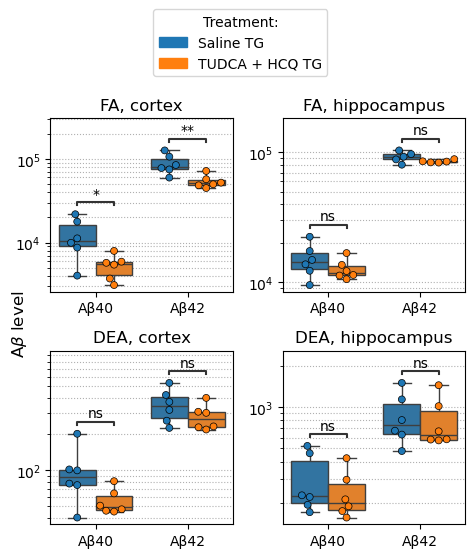

In [16]:
def my_plot_ax(ax, treatments, study, x, hue, subsetd, palette,
               pairs=None, pvals=None, do_annot=False, Abeta_long=Abeta_long):
    b = (Abeta_long.Treatment.isin(treatments)) & (Abeta_long.Study == study)
    b = b & (Abeta_long[list(subsetd.keys())[0]] == list(subsetd.values())[0]) & (Abeta_long[list(subsetd.keys())[1]] == list(subsetd.values())[1])
    data = Abeta_long.loc[b]
    data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)
    sns.swarmplot(x=x, y='Ab', hue=hue, edgecolor='k', linewidth=0.5, dodge=True, palette=palette, data=data, ax=ax, legend=False)
    sns.boxplot(x=x, y='Ab', hue=hue, palette=palette, data=data, ax=ax, legend=False, whis=(0, 100))
    ax.set_yscale('log')
    ax.set_title(', '.join(list(subsetd.values())))
    ax.grid(which='both', axis='y', linestyle='dotted')
    if do_annot and not (pvals is None or pairs is None):
        annot = Annotator(ax, pairs=pairs, data=data, hue='Treatment', x='Alloform', y='Ab')
        annot.configure(loc='inside', text_format='star').set_pvalues(pvalues=pvals)
        #formatstr = r'$p =${:.0g}'
        #l = [formatstr.format(p) for p in pvals]
        #annot.set_custom_annotations(l)
        annot.annotate()
    return(ax)

def my_plot(treatments=['Saline TG', 'TUDCA + HCQ TG'], study='CO28154', colors=['C0', 'C1'],
            pairs=[(('Aβ40', 'Saline TG'), ('Aβ40', 'TUDCA + HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'TUDCA + HCQ TG'))],
            ref_cond=['FA', 'cortex'], ttest_res=ttest_res):
    palette = dict(zip(treatments, colors))
    fig, ax = plt.subplots(2, 2, figsize=(4.8, 4.8))
    for i, fraction in enumerate(['FA', 'DEA']):
        for j, region in enumerate(['cortex', 'hippocampus']):
            axi = ax[i, j]
            do_annot = (fraction == ref_cond[0]) & (region == ref_cond[1])
            pvals_df = ttest_res.xs(study, level='study').xs(region, level='region').xs(fraction, level='fraction')
            pvals = [pvals_df.xs(p[1][0], level='alloform').loc[(p[0][1], p[1][1]), 'pvalue'] for p in pairs]
            axi = my_plot_ax(axi, treatments=treatments, study=study, x='Alloform', hue='Treatment',
                             subsetd={'Fraction': fraction, 'Region': region}, palette=palette,
                             pairs=pairs, pvals=pvals, do_annot=True)
            axi.set_xlabel('')
            axi.set_ylabel('')
    handles = [mpatches.Patch(color=c) for c in palette.values()]
    fig.legend(handles=handles, labels=treatments, loc='lower center', bbox_to_anchor=(0.5, 1.0), title='Treatment:')
    fig.tight_layout()
    fig.supylabel(r'A$\beta$ level')
    #fig.supxlabel(r'Alloform')
    return((fig, ax))

treatments = ['Saline TG', 'TUDCA + HCQ TG']
colors = ['C0', 'C1']
pairs = [(('Aβ40', 'Saline TG'), ('Aβ40', 'TUDCA + HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'TUDCA + HCQ TG'))]
#pvals = [results_params[('CO28154', 'TUDCA and HCQ')].loc['Treatment[T.TUDCA + HCQ TG]', ('both sexes', 'pvalues')]]
fig, ax = my_plot(treatments=treatments, study='CO28154', colors=colors, pairs=pairs)
attila_utils.savefig(fig, 'boxplot-Abeta-TUDCA-and-HCQ')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA + HCQ TG' < 'Saline WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:4.128e-03
Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:2.325e-02
Aβ42_Saline TG vs. Aβ42_Saline WT: Custom statistical test, P_val:3.535e-07
Aβ40_Saline TG vs. Aβ40_Saline WT: Custom statistical test, P_val:nan


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA + HCQ TG' < 'Saline WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:1.210e-01
Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:3.028e-01
Aβ42_Saline TG vs. Aβ42_Saline WT: Custom statistical test, P_val:nan
Aβ40_Saline TG vs. Aβ40_Saline WT: Custom statistical test, P_val:nan


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA + HCQ TG' < 'Saline WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:2.135e-01
Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:6.450e-02
Aβ42_Saline TG vs. Aβ42_Saline WT: Custom statistical test, P_val:9.773e-07
Aβ40_Saline TG vs. Aβ40_Saline WT: Custom statistical test, P_val:5.919e-05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA + HCQ TG: Custom statistical test, P_val:7.848e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', 'Saline TG', ..., 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT', 'Saline WT']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA + HCQ TG' < 'Saline WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


Aβ40_Saline TG vs. Aβ40_TUDCA + HCQ TG: Custom statistical test, P_val:4.842e-01
Aβ42_Saline TG vs. Aβ42_Saline WT: Custom statistical test, P_val:nan
Aβ40_Saline TG vs. Aβ40_Saline WT: Custom statistical test, P_val:nan


['named-figure/boxplot-Abeta-TUDCA-and-HCQ-with-WT.png',
 'named-figure/boxplot-Abeta-TUDCA-and-HCQ-with-WT.pdf']

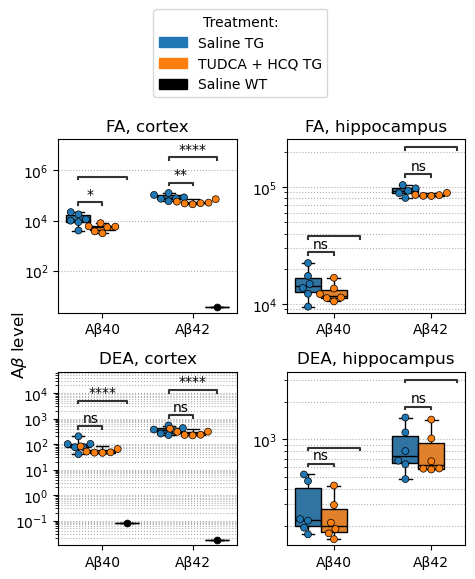

In [17]:
treatments = ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT']
colors = ['C0', 'C1', 'k']
pairs = [(('Aβ40', 'Saline TG'), ('Aβ40', 'TUDCA + HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'TUDCA + HCQ TG')),
         (('Aβ40', 'Saline TG'), ('Aβ40', 'Saline WT')), (('Aβ42', 'Saline TG'), ('Aβ42', 'Saline WT'))]
fig, ax = my_plot(treatments=treatments, study='CO28154', colors=colors, pairs=pairs)
attila_utils.savefig(fig, 'boxplot-Abeta-TUDCA-and-HCQ-with-WT')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA TG' < 'HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA TG: Custom statistical test, P_val:1.065e-01
Aβ40_Saline TG vs. Aβ40_TUDCA TG: Custom statistical test, P_val:2.458e-01
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:3.728e-01
Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:8.958e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA TG' < 'HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA TG: Custom statistical test, P_val:8.797e-01
Aβ40_Saline TG vs. Aβ40_TUDCA TG: Custom statistical test, P_val:6.028e-01
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:8.452e-01
Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:7.548e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA TG' < 'HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA TG: Custom statistical test, P_val:2.754e-01
Aβ40_Saline TG vs. Aβ40_TUDCA TG: Custom statistical test, P_val:7.078e-02
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:5.254e-01
Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:8.797e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG', 'TUDCA TG']
Length: 36
Categories (3, object): ['Saline TG' < 'TUDCA TG' < 'HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ42_Saline TG vs. Aβ42_TUDCA TG: Custom statistical test, P_val:6.261e-01
Aβ40_Saline TG vs. Aβ40_TUDCA TG: Custom statistical test, P_val:8.518e-02
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:3.903e-01
Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:5.435e-01


['named-figure/boxplot-Abeta-TUDCA-or-HCQ.png',
 'named-figure/boxplot-Abeta-TUDCA-or-HCQ.pdf']

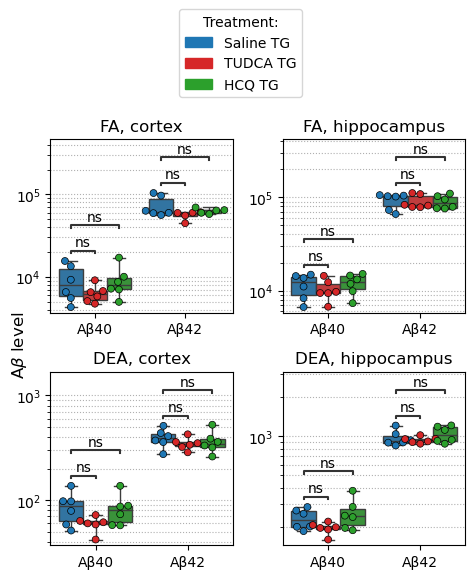

In [18]:
treatments = ['Saline TG', 'TUDCA TG', 'HCQ TG']
colors = ['C0', 'C3', 'C2']
pairs = [(('Aβ40', 'Saline TG'), ('Aβ40', 'TUDCA TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'TUDCA TG')),
         (('Aβ40', 'Saline TG'), ('Aβ40', 'HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'HCQ TG'))]
fig, ax = my_plot(treatments=treatments, study='CO28152', colors=colors, pairs=pairs)
attila_utils.savefig(fig, 'boxplot-Abeta-TUDCA-or-HCQ')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG']
Length: 60
Categories (5, object): ['Saline TG' < 'HCQ TG' < 'HCQ nano TG' < 'R-HCQ TG' < 'S-HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:8.958e-01
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:3.728e-01
Aβ40_Saline TG vs. Aβ40_HCQ nano TG: Custom statistical test, P_val:6.369e-01
Aβ42_Saline TG vs. Aβ42_HCQ nano TG: Custom statistical test, P_val:4.994e-01
Aβ40_Saline TG vs. Aβ40_R-HCQ TG: Custom statistical test, P_val:1.831e-01
Aβ42_Saline TG vs. Aβ42_R-HCQ TG: Custom statistical test, P_val:1.233e-01
Aβ40_Saline TG vs. Aβ40_S-HCQ TG: Custom statistical test, P_val:9.432e-01
Aβ42_Saline TG vs. Aβ42_S-HCQ TG: Custom statistical test, P_val:3.937e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Saline TG

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG']
Length: 60
Categories (5, object): ['Saline TG' < 'HCQ TG' < 'HCQ nano TG' < 'R-HCQ TG' < 'S-HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:8.452e-01
Aβ40_Saline TG vs. Aβ40_HCQ nano TG: Custom statistical test, P_val:1.272e-01
Aβ42_Saline TG vs. Aβ42_HCQ nano TG: Custom statistical test, P_val:1.824e-01
Aβ40_Saline TG vs. Aβ40_R-HCQ TG: Custom statistical test, P_val:1.673e-01
Aβ42_Saline TG vs. Aβ42_R-HCQ TG: Custom statistical test, P_val:1.125e-01
Aβ40_Saline TG vs. Aβ40_S-HCQ TG: Custom statistical test, P_val:9.920e-01
Aβ42_Saline TG vs. Aβ42_S-HCQ TG: Custom statistical test, P_val:4.836e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG']
Length: 60
Categories (5, object): ['Saline TG' < 'HCQ TG' < 'HCQ nano TG' < 'R-HCQ TG' < 'S-HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:8.797e-01
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:5.254e-01
Aβ40_Saline TG vs. Aβ40_HCQ nano TG: Custom statistical test, P_val:7.999e-01
Aβ42_Saline TG vs. Aβ42_HCQ nano TG: Custom statistical test, P_val:8.623e-01
Aβ40_Saline TG vs. Aβ40_R-HCQ TG: Custom statistical test, P_val:3.074e-01
Aβ42_Saline TG vs. Aβ42_R-HCQ TG: Custom statistical test, P_val:3.038e-02
Aβ40_Saline TG vs. Aβ40_S-HCQ TG: Custom statistical test, P_val:6.718e-01
Aβ42_Saline TG vs. Aβ42_S-HCQ TG: Custom statistical test, P_val:8.705e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', 'HCQ TG', ..., 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG', 'S-HCQ TG']
Length: 60
Categories (5, object): ['Saline TG' < 'HCQ TG' < 'HCQ nano TG' < 'R-HCQ TG' < 'S-HCQ TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Saline TG vs. Aβ40_HCQ TG: Custom statistical test, P_val:5.435e-01
Aβ42_Saline TG vs. Aβ42_HCQ TG: Custom statistical test, P_val:3.903e-01
Aβ40_Saline TG vs. Aβ40_HCQ nano TG: Custom statistical test, P_val:1.768e-01
Aβ42_Saline TG vs. Aβ42_HCQ nano TG: Custom statistical test, P_val:9.395e-02
Aβ40_Saline TG vs. Aβ40_R-HCQ TG: Custom statistical test, P_val:3.277e-01
Aβ42_Saline TG vs. Aβ42_R-HCQ TG: Custom statistical test, P_val:3.761e-01
Aβ40_Saline TG vs. Aβ40_S-HCQ TG: Custom statistical test, P_val:9.652e-01
Aβ42_Saline TG vs. Aβ42_S-HCQ TG: Custom statistical test, P_val:7.892e-02


['named-figure/boxplot-Abeta-HCQ-analogs.png',
 'named-figure/boxplot-Abeta-HCQ-analogs.pdf']

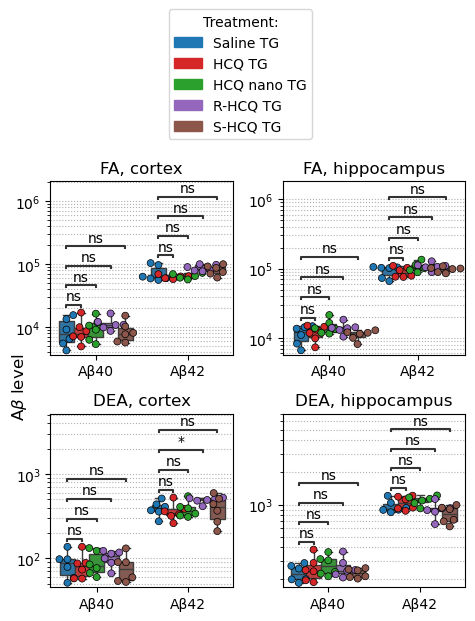

In [19]:
treatments = ['Saline TG', 'HCQ TG', 'HCQ nano TG', 'R-HCQ TG', 'S-HCQ TG']
colors = ['C0', 'C3', 'C2', 'C4', 'C5', 'C6']
pairs = [
    (('Aβ40', 'Saline TG'), ('Aβ40', 'HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'HCQ TG')),
    (('Aβ40', 'Saline TG'), ('Aβ40', 'HCQ nano TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'HCQ nano TG')),
    (('Aβ40', 'Saline TG'), ('Aβ40', 'R-HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'R-HCQ TG')),
    (('Aβ40', 'Saline TG'), ('Aβ40', 'S-HCQ TG')), (('Aβ42', 'Saline TG'), ('Aβ42', 'S-HCQ TG')),
]
fig, ax = my_plot(treatments=treatments, study='CO28152', colors=colors, pairs=pairs)
attila_utils.savefig(fig, 'boxplot-Abeta-HCQ-analogs')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG']
Length: 48
Categories (4, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:8.165e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:7.258e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:2.291e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:2.358e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:7.345e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:6.326e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundi

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG']
Length: 48
Categories (4, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:4.300e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:4.081e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:3.734e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:3.191e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:5.345e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:6.999e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG']
Length: 48
Categories (4, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:7.933e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:3.850e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:4.310e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:8.467e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:6.158e-01


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG', 'Vehicle (Arundine) TG']
Length: 48
Categories (4, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:4.526e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:6.442e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:3.687e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:3.299e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:5.722e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:8.204e-01


['named-figure/boxplot-Abeta-arundine.png',
 'named-figure/boxplot-Abeta-arundine.pdf']

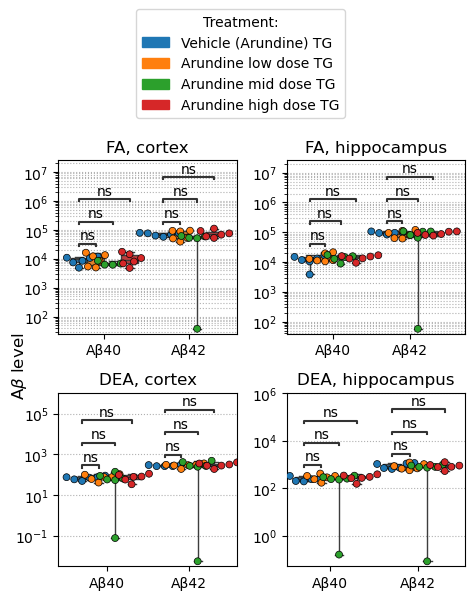

In [20]:
treatments = ['Vehicle (Arundine) TG', 'Arundine low dose TG', 'Arundine mid dose TG', 'Arundine high dose TG']
colors = ['C' + str(i) for i, t in enumerate(treatments)]
pairs = [
    (('Aβ40', 'Vehicle (Arundine) TG'), ('Aβ40', 'Arundine low dose TG')), (('Aβ42', 'Vehicle (Arundine) TG'), ('Aβ42', 'Arundine low dose TG')),
    (('Aβ40', 'Vehicle (Arundine) TG'), ('Aβ40', 'Arundine mid dose TG')), (('Aβ42', 'Vehicle (Arundine) TG'), ('Aβ42', 'Arundine mid dose TG')),
    (('Aβ40', 'Vehicle (Arundine) TG'), ('Aβ40', 'Arundine high dose TG')), (('Aβ42', 'Vehicle (Arundine) TG'), ('Aβ42', 'Arundine high dose TG')),
]
pvals = [results_params[('CO28154', 'Arundine')].loc['Treatment[T.' + t + ']', ('both sexes', 'pvalues')] for t in treatments[1:]]
fig, ax = my_plot(treatments=treatments, study='CO28154', colors=colors, pairs=pairs)
attila_utils.savefig(fig, 'boxplot-Abeta-arundine')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT']
Length: 60
Categories (5, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG' < 'Vehicle (Arundine) WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:8.165e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:7.258e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:2.291e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:2.358e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:7.345e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:6.326e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Vehicle (Arundine) WT: Custom statistical test, P_val:nan
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Vehicle (Arundine) WT: Custom statistical test, P_val:2.586e-08


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT']
Length: 60
Categories (5, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG' < 'Vehicle (Arundine) WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:3.285e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:4.300e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:4.081e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:3.734e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:3.191e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:5.345e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Vehicle (Arundine) WT: Custom statistical test, P_val:nan
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Vehicle (Arundine) WT: Custom statistical test, P_val:nan


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT']
Length: 60
Categories (5, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG' < 'Vehicle (Arundine) WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:6.999e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:7.933e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:3.850e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:4.310e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:8.467e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:6.158e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Vehicle (Arundine) WT: Custom statistical test, P_val:6.779e-07
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Vehicle (Arundine) WT: Custom statistical test, P_val:3.120e-08


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_31764/3331077826.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', 'Arundine low dose TG', ..., 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT', 'Vehicle (Arundine) WT']
Length: 60
Categories (5, object): ['Vehicle (Arundine) TG' < 'Arundine low dose TG' < 'Arundine mid dose TG' < 'Arundine high dose TG' < 'Vehicle (Arundine) WT']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Treatment'] = pd.Categorical(data.Treatment, ordered=True, categories=treatments)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine low dose TG: Custom statistical test, P_val:4.526e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine low dose TG: Custom statistical test, P_val:6.442e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine mid dose TG: Custom statistical test, P_val:3.687e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine mid dose TG: Custom statistical test, P_val:3.299e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Arundine high dose TG: Custom statistical test, P_val:5.722e-01
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Arundine high dose TG: Custom statistical test, P_val:8.204e-01
Aβ40_Vehicle (Arundine) TG vs. Aβ40_Vehicle (Arundine) WT: Custom statistical test, P_val:nan
Aβ42_Vehicle (Arundine) TG vs. Aβ42_Vehicle (Arundine) WT: Custom statistical test, P_val:nan


['named-figure/boxplot-Abeta-arundine-with-WT.png',
 'named-figure/boxplot-Abeta-arundine-with-WT.pdf']

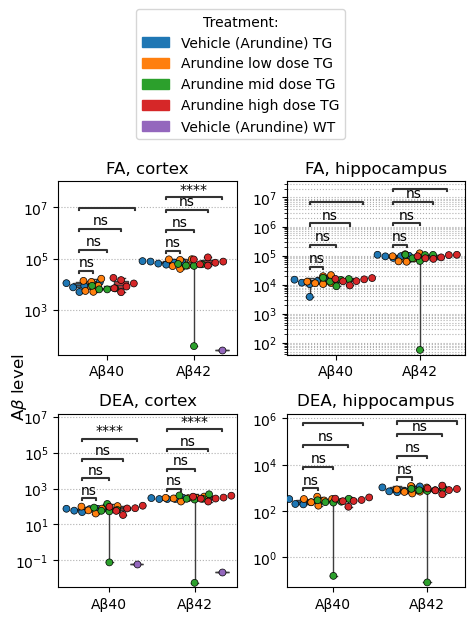

In [21]:
treatments = ['Vehicle (Arundine) TG', 'Arundine low dose TG', 'Arundine mid dose TG', 'Arundine high dose TG', 'Vehicle (Arundine) WT']
colors = ['C' + str(i) for i, t in enumerate(treatments)]
pairs = pairs + [(('Aβ40', 'Vehicle (Arundine) TG'), ('Aβ40', 'Vehicle (Arundine) WT')), (('Aβ42', 'Vehicle (Arundine) TG'), ('Aβ42', 'Vehicle (Arundine) WT'))]
fig, ax = my_plot(treatments=treatments, study='CO28154', colors=colors, pairs=pairs)
attila_utils.savefig(fig, 'boxplot-Abeta-arundine-with-WT')

In [22]:
%connect_info

{
  "shell_port": 53604,
  "iopub_port": 53605,
  "stdin_port": 53606,
  "control_port": 53608,
  "hb_port": 53607,
  "ip": "127.0.0.1",
  "key": "eef4010e-55ffa88fa659869b22c558cb",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "conda-base-py",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-08-08-biochemistry/2024-08-08-biochemistry.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9faf4389-7397-45fc-86b2-2efa1d60effc.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
